In [1]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
X = np.load("data/emnist/images.npy")
y = np.load("data/emnist/labels.npy")

In [3]:
AB_X = X[y<=2, ...]
AB_y = y[y<=2] - 1 # 0 si c'est un A, 1 si c'est un B

In [4]:
X_train, X_test, y_train, y_test = train_test_split(AB_X, AB_y, train_size=20, stratify=AB_y, shuffle=True)

In [5]:
np.save("data/emnist_ab/images_test.npy", X_test)
np.save("data/emnist_ab/labels_test.npy", y_test)
np.save("data/emnist_ab/images_train.npy", X_train)
np.save("data/emnist_ab/labels_train.npy", y_train)

In [36]:
X = np.load("data/emnist_ab/images_train.npy")
y = np.load("data/emnist_ab/labels_train.npy")
X_test = np.load("data/emnist_ab/images_test.npy")
y_test = np.load("data/emnist_ab/labels_test.npy")
X, X_test = map(lambda x: x/255.0, (X, X_test))

In [37]:
pd.Series(y).value_counts() # Seulement dix images de chaque classe !

1    10
0    10
dtype: int64

In [38]:
# Il faut séparer encore le train en deux (créer un validation set) pour pouvoir vérifier que l'on overfit pas trop
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, shuffle=True, stratify=y)

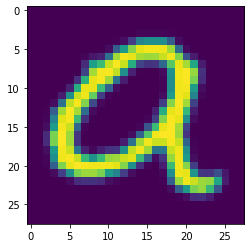

In [39]:
plt.imshow(X_train[0].squeeze())

Si l'on tente d'entraîner un modèle d'une taille importante sur les 10 images dont on dispose, il tombera dans le sur-apprentissage très rapidement.

Il faut donc utiliser plusieurs méthodes pour limiter cela :
- Utiliser un modèle avec peu de paramètres : Vous pouvez utiliser `model.summary()` pour vérifier le nombre de paramètres entraînables du modèle, il doit être petit afin de limiter l'overfitting.
- Utiliser le validation set pour arrêter l'entraînement quand la loss sur le validation set commence à remonter : cela s'appelle l'Early Stopping.

In [40]:
# Construire et compiler ici votre modèle.
basic_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(4, 3, activation="relu", input_shape=(28, 28, 1), padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(4, 3, activation="relu", padding="same"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(1, 3, activation="relu", padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

basic_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"],
)

In [41]:
# Afficher ici le summary du modèle
basic_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 4)         40        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 4)         0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 14, 14, 4)         148       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 4)           0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 7, 7, 1)           37        
_________________________________________________________________
flatten_4 (Flatten)          (None, 49)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                

En utilisant `model.summary()`, vérifiez combien de paramètres entraînables a votre modèle.

Essayez de faire en sorte que ce nombre ne dépasse pas 1000 !

Pour réduire le nombre de paramètres (et donc l'overfitting), on peut utiliser divers éléments architecturaux comme les convolutions ou le MaxPooling par exemple.

In [45]:
# Entraîner ici votre modèle
basic_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)],
)

Epoch 1/100
1/1 [==============================] - 0s 58ms/step - loss: 0.6757 - accuracy: 0.5000 - val_loss: 0.7448 - val_accuracy: 0.4000
Epoch 2/100
1/1 [==============================] - 0s 67ms/step - loss: 0.6712 - accuracy: 0.5000 - val_loss: 0.7444 - val_accuracy: 0.4000
Epoch 3/100
1/1 [==============================] - 0s 67ms/step - loss: 0.6668 - accuracy: 0.5000 - val_loss: 0.7441 - val_accuracy: 0.4000
Epoch 4/100
1/1 [==============================] - 0s 61ms/step - loss: 0.6623 - accuracy: 0.5000 - val_loss: 0.7437 - val_accuracy: 0.4000
Epoch 5/100
1/1 [==============================] - 0s 60ms/step - loss: 0.6580 - accuracy: 0.5000 - val_loss: 0.7436 - val_accuracy: 0.4000
Epoch 6/100
1/1 [==============================] - 0s 58ms/step - loss: 0.6536 - accuracy: 0.6000 - val_loss: 0.7434 - val_accuracy: 0.4000
Epoch 7/100
1/1 [==============================] - 0s 68ms/step - loss: 0.6493 - accuracy: 0.6000 - val_loss: 0.7433 - val_accuracy: 0.4000
Epoch 8/100
1/1 [===

In [46]:
# Evaluation du modèle
# Attention : le test set doit être utilisé le moins de fois possible afin de ne pas overfitter dessus.
# Ne faites donc pas plusieurs essais jusqu'à avoir un bon score sur le test set mais fiez-vous à votre validation set.
# En effet, le test set représente "la réalité", ce à quoi vous n'avez pas accès, et en pratique, vous n'aurez droit qu'à un seul essai.
basic_model.evaluate(X_test, y_test)

212/212 [==============================] - 1s 3ms/step - loss: 0.6873 - accuracy: 0.5557


[0.6872542500495911, 0.5556703805923462]

Chez moi, le modèle atteint déjà une accuracy de 60-65%. C'est déjà la preuve qu'il apprend mais on peut faire mieux.

Avec data augmentation :

In [23]:
tf.keras.preprocessing.image.ImageDataGenerator?

In [47]:
# Utilisez tf.keras.preprocessing.image.ImageDataGenerator pour créer un objet generator
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=2,
    height_shift_range=2,
    shear_range=10,
    horizontal_flip=False,
    vertical_flip=False,
)
generator.fit(X_train)

# Construisez ici un modèle avec plus de paramètres que le précédent :
# Grâce à la data augmentation, il va beaucoup moins overfitter que le précédent.
aug_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation="relu", input_shape=(28, 28, 1), padding="same"),
    tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(32, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(16, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(8, 3, activation="relu", padding="same"),
    tf.keras.layers.Conv2D(4, 3, activation="relu", padding="same"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

aug_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"],
)

aug_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 16)        4624      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 28, 28, 8)         1160      
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 28, 28, 4)         292       
_________________________________________________________________
flatten_5 (Flatten)          (None, 3136)             

In [48]:
# Entraînez ici votre modèle en utilisant generator.flow(X_train, y_train)
aug_model.fit(
    generator.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
)

Epoch 1/100
1/1 [==============================] - 0s 351ms/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 0.6923 - val_accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 58ms/step - loss: 0.6907 - accuracy: 0.5000 - val_loss: 0.6925 - val_accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 68ms/step - loss: 0.6857 - accuracy: 0.5000 - val_loss: 0.6920 - val_accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 0s 62ms/step - loss: 0.6742 - accuracy: 0.5000 - val_loss: 0.6917 - val_accuracy: 0.5000
Epoch 5/100
1/1 [==============================] - 0s 59ms/step - loss: 0.6615 - accuracy: 0.5000 - val_loss: 0.6912 - val_accuracy: 0.5000
Epoch 6/100
1/1 [==============================] - 0s 63ms/step - loss: 0.6410 - accuracy: 0.5000 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 7/100
1/1 [==============================] - 0s 62ms/step - loss: 0.5957 - accuracy: 0.6000 - val_loss: 0.6930 - val_accuracy: 0.6000
Epoch 8/100
1/1 [==

In [49]:
aug_model.evaluate(X_test, y_test)

212/212 [==============================] - 1s 5ms/step - loss: 0.3756 - accuracy: 0.8687


[0.3755776584148407, 0.8687241673469543]

On a déjà atteint une bien meilleure performance grâce à l'augmentation de données. En effet, celle-ci limite beaucoup l'overfitting et nous permet donc d'utiliser un modèle bien plus gros.

Mais l'on peut vraisemblablement faire encore mieux en combinant cette approche à du transfer learning. Pour ce faire, on va utilser le modèle entraîné précédemment sur le jeu de données MNIST (reconnaissance de chiffres), retirer sa dernière couche et la remplacer par une couche Dense(1) afin qu'elle soit adaptée au problème actuel.

Nous allons ensuite réentraîner le modèle ainsi modifié, en rendant ses couches inférieures non-entraînables.

In [54]:
# Remplacer par le chemin de votre modèle
mnist_model = tf.keras.models.load_model("models/mnist_model.h5")
mnist_model.pop() # On enlève la dernière couche

In [55]:
mnist_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 14, 14, 8)         584       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 7, 7, 1)           73        
_________________________________________________________________
flatten_8 (Flatten)          (None, 49)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

Construisons un nouveau modèle à partir de cet ancien.

In [59]:
mnist_model.trainable = False
transfer_model = tf.keras.Sequential([
    mnist_model,
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

transfer_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=["accuracy"],
)

transfer_model.fit(
    generator.flow(X_train, y_train, batch_size=32),
    #X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
)

Epoch 1/100
1/1 [==============================] - 0s 234ms/step - loss: 3.4541 - accuracy: 0.5000 - val_loss: 4.0895 - val_accuracy: 0.5000
Epoch 2/100
1/1 [==============================] - 0s 67ms/step - loss: 2.9195 - accuracy: 0.5000 - val_loss: 4.0248 - val_accuracy: 0.5000
Epoch 3/100
1/1 [==============================] - 0s 67ms/step - loss: 3.5493 - accuracy: 0.5000 - val_loss: 3.9609 - val_accuracy: 0.5000
Epoch 4/100
1/1 [==============================] - 0s 77ms/step - loss: 3.0619 - accuracy: 0.5000 - val_loss: 3.8982 - val_accuracy: 0.5000
Epoch 5/100
1/1 [==============================] - 0s 78ms/step - loss: 3.0273 - accuracy: 0.5000 - val_loss: 3.8353 - val_accuracy: 0.5000
Epoch 6/100
1/1 [==============================] - 0s 61ms/step - loss: 2.2765 - accuracy: 0.5000 - val_loss: 3.7718 - val_accuracy: 0.5000
Epoch 7/100
1/1 [==============================] - 0s 59ms/step - loss: 3.7623 - accuracy: 0.5000 - val_loss: 3.7079 - val_accuracy: 0.5000
Epoch 8/100
1/1 [==

In [60]:
transfer_model.evaluate(X_test, y_test)

212/212 [==============================] - 1s 4ms/step - loss: 0.8177 - accuracy: 0.6883


[0.817651093006134, 0.6882752776145935]

Chez moi, la performance est comparable au modèle avec data augmentation.

Cela peut s'expliquer par le fait que la tâche de reconnaissance des A et des B n'est pas très difficile et la data augmentation suffit à recouvrir une grande partie des cas possibles. Si on avait choisi une tâche plus difficile (par exemple reconnaître les 26 lettres de l'alphabet, je pense que le transfer learning aurait mieux fonctionné que la data augmentation seule.